# Comparing Adversarial robustness performance
This notebook meta learns plasticity rules on an 8 dimensional halfspace, and then runs adversarial robustness performance on MNIST data

In [1]:
%load_ext autoreload
%autoreload 2
%run FF_common.ipynb

In [2]:
print("****Getting MNIST Data****")
minst_X_train, _mnist_y_train, mnist_X_test, mnist_y_test = quick_get_data('mnist', 784)

****Getting MNIST Data****
mnist_train: 60000
mnist_test: 10000


In [14]:
from torchviz import make_dot
from AdversarialExamples import adversarial_example, random_not_true_label
%load_ext autoreload
%autoreload 2
# A function to manually switch graadient computation on for every single parameter in the network, 
# even if we arent updating them

def enable_grad_everywhere(model,requires_grad=True):
    #Turn on requires_grad everywhere by converting to parameters.
    
    try:
        #FF-ANN
        for i,hidden_weight in enumerate(model.hidden_weights):
            if hidden_weight is not None:
                model.hidden_weights[i] = torch.nn.Parameter( hidden_weight,requires_grad=requires_grad )

            model.hidden_biases[i] = None #torch.nn.Parameter(model.hidden_biases[i],requires_grad=requires_grad )            
    except:
        #RNN
        model.graph_weights = torch.nn.Parameter( model.graph_weights,requires_grad=requires_grad )
        model.graph_bias = torch.nn.Parameter( model.graph_bias,requires_grad=requires_grad )
        
    model.input_weights = torch.nn.Parameter( model.input_weights,requires_grad=requires_grad )
    model.output_weights = torch.nn.Parameter( model.output_weights,requires_grad=requires_grad )
    model.output_bias = None #torch.nn.Parameter( model.output_bias,requires_grad=requires_grad )
    

def plot_random_adversary(brain_model, example_index=768,perturb_level=3,show_grad=False):
    ####################################
    # Try different values of example_index and perturb_level to see how the image changes and what it's meant to look like
    ####################################

    examp_X = torch.from_numpy(mnist_X_test[example_index]).double()
    examp_Y = mnist_y_test[example_index]
    not_Y = random_not_true_label(examp_Y)
    print("****Turning on Gradients****")
    enable_grad_everywhere(brain_model)
    print("****Creating Adversary****")
    adv_X = adversarial_example(
        examp_X.reshape(1, -1), torch.tensor([not_Y], dtype=torch.long), 
        brain_model.forward_pass, eps=perturb_level, lr=5e-3,verbose=True,show_grad=show_grad,full_net=brain_model)

    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(examp_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[0].set_title( 'Original - '+ str(examp_Y))
    ax[1].imshow(adv_X.detach().reshape(28, 28), vmin=0, vmax=1, cmap='Greys')
    ax[1].set_title( "Makes NN think it's - " + str(not_Y))
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# IMPORTANT: Henceforth, we use GD directly on inputs but use plasticity rules in the output and hidden layers.
opts_up = Options(gd_input=True,
                  use_graph_rule=True,
                  gd_graph_rule=True,
                  use_output_rule=True,
                  gd_output_rule=True,
                  gd_output=False)
opts_down = Options(gd_input=True,
                    use_graph_rule=True,
                    gd_graph_rule=False,  # Not meta-trainable anymore!
                    use_output_rule=True,
                    gd_output_rule=False,  # Not meta-trainable anymore!
                    gd_output=False)
scheme = UpdateScheme(cross_entropy_loss=True,
                      mse_loss=False,
                      update_misclassified_only=False,
                      update_all_edges=True)

# Feed-forward brain config.
n_up = 8  # Input layer size for meta-learning.
n_down = 784  # Input layer size for desired task training.
m_up = 2  # Output layer size.
m_down = 10
l = 2  # Number of hidden layers.
w = 100  # Width of hidden layers.
p = 0.5  # Connectivity probability.
cap = 50  # Number of nodes firing per layer.
dataset_up = 'halfspace'
dataset_down = 'mnist'

# Training config.
num_runs = 1
num_rule_epochs = 50
num_epochs_upstream = 1
num_epochs_downstream = 1

In [57]:
# All models tested go here
brain_prepost_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), 
    options=opts_up, update_scheme=scheme)
brain_prepost_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=TableRule_PrePost(),
    output_rule=TableRule_PrePost(), 
    options=opts_down, update_scheme=scheme)

brain_fullgd_down_fact = lambda: FFBrainNet(n_down, m_down, l, w, p, cap,full_gd=True,gd_input=True,gd_output=True)

brain_rnn_up_fact = lambda: LocalNet(n_up, m_up, 64, p, 32, 3, options=opts_up, update_scheme=scheme)
brain_rnn_down_fact = lambda: LocalNet(n_down, m_down, 64, p, 32, 3, options=opts_down, update_scheme=scheme)

brain_prepostcount_up_fact = lambda: FFLocalNet(
    n_up, m_up, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_up, update_scheme=scheme)
brain_prepostcount_down_fact = lambda: FFLocalNet(
    n_down, m_down, l, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_down, update_scheme=scheme)

brain_prepostcount_up_fact_l3 = lambda: FFLocalNet(
    n_up, m_up, 3, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_up, update_scheme=scheme)
brain_prepostcount_down_fact_l3 = lambda: FFLocalNet(
    n_down, m_down, 3, w, p, cap, hl_rules=TableRule_PrePostCount(),
    output_rule=TableRule_PrePostCount(), options=opts_down, update_scheme=scheme)

# Prepost

In [6]:
stats, brain_prepost_trained = evaluate_generalization(
    brain_prepost_up_fact, 
    brain_prepost_down_fact, 
    n_up, 
    n_down, 
    dataset_up='halfspace',dataset_down='mnist', 
    num_runs=1, 
    num_rule_epochs=num_rule_epochs, 
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,
    get_model=True
)

 ... (more hidden) ...


Run 1 / 1...
Meta-learning on halfspace...


 ... (more hidden) ...


Last loss: 0.3485
Last train accuracy: 0.9705
Last test accuracy: 0.9640
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.1000
INITIAL test accuracy: 0.1000
Epoch 1 / 1 ...


 ... (more hidden) ...


Last loss: 2.1478
Last train accuracy: 0.2990
Last test accuracy: 0.3097



In [50]:
#plot_random_adversary(brain_prepost_trained,show_grad=True)

In [51]:
# x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
# out = brain_prepost_trained.forward_pass(x)
# make_dot(out)

# Prepost Count

In [22]:
stats, brain_prepostcount_trained = evaluate_generalization(
    brain_prepostcount_up_fact, 
    brain_prepostcount_down_fact, 
    n_up, 
    n_down, 
    dataset_up='halfspace',dataset_down='mnist', 
    num_runs=1, 
    num_rule_epochs=num_rule_epochs, 
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,
    get_model=True
)

 ... (more hidden) ...


Run 1 / 1...
Meta-learning on halfspace...


 ... (more hidden) ...


Last loss: 0.3659
Last train accuracy: 0.9521
Last test accuracy: 0.9529
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.1000
INITIAL test accuracy: 0.1000
Epoch 1 / 1 ...


 ... (more hidden) ...


Last loss: 2.2412
Last train accuracy: 0.2103
Last test accuracy: 0.2192



In [58]:
stats, brain_prepostcount_l3_trained = evaluate_generalization(
    brain_prepostcount_up_fact_l3, 
    brain_prepostcount_down_fact_l3, 
    n_up, 
    n_down, 
    dataset_up='halfspace',dataset_down='mnist', 
    num_runs=1, 
    num_rule_epochs=num_rule_epochs, 
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,
    get_model=True
)

 ... (more hidden) ...


Run 1 / 1...
Meta-learning on halfspace...


 ... (more hidden) ...


Last loss: 0.3784
Last train accuracy: 0.9259
Last test accuracy: 0.9113
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.1000
INITIAL test accuracy: 0.1000
Epoch 1 / 1 ...


 ... (more hidden) ...


Last loss: 2.2645
Last train accuracy: 0.1699
Last test accuracy: 0.1727



# Vanilla Full GD

In [16]:
brain_fullgd_trained = brain_fullgd_down_fact()
X_train, y_train, X_test, y_test = quick_get_data(dataset_down, n_down)
print('Training NEW brain instance (WITH backprop) on ' + dataset_down + '...')
stats_down = train_downstream(
    X_train, y_train, brain_fullgd_trained, num_epochs=num_epochs_downstream,
    batch_size=100, vanilla=True, learn_rate=5e-3,
    X_test=X_test, y_test=y_test, verbose=False, stats_interval=500)

mnist_train: 60000
mnist_test: 10000
Training NEW brain instance (WITH backprop) on mnist...
INITIAL train accuracy: 0.0814
INITIAL test accuracy: 0.0849
Epoch 1 / 1 ...


 ... (more hidden) ...


Last loss: 1.7079
Last train accuracy: 0.7607
Last test accuracy: 0.7584


****Turning on Gradients****
****Creating Adversary****
Loss/cnt/eps_curr/Y: 2.461150171515705 1 0.2663270473470781 1
Input Gradients
tensor([[ 1.1402e-10, -6.1703e-11, -7.1077e-11, -3.5916e-11, -1.8007e-10,
          7.3359e-11,  5.3078e-11,  1.3472e-10,  9.4665e-11,  1.4909e-11,
         -5.9255e-11,  1.7517e-10,  2.6315e-10, -9.8855e-11, -7.2223e-11,
         -2.5793e-11,  6.1451e-11, -3.3907e-11, -3.2789e-11, -3.9123e-11,
          7.6931e-11, -8.7632e-11,  1.1103e-10,  7.5796e-11,  9.8120e-11,
         -1.2702e-10, -6.3084e-11,  1.4384e-10, -7.8106e-11, -1.2347e-10,
         -5.4370e-10,  9.3171e-11, -2.9217e-10,  2.6740e-10,  1.9612e-10,
         -1.5090e-10, -5.0719e-11, -6.4622e-11, -4.1105e-10,  6.0384e-11,
         -4.1733e-12,  8.6165e-11, -5.2960e-11,  6.1183e-10, -3.4137e-10,
         -1.6038e-10, -1.9857e-10,  1.7367e-10, -2.0389e-11, -2.2668e-10,
          9.4949e-11, -1.5643e-10, -6.4468e-13,  1.0065e-10,  2.7858e-11,
         -7.2327e-11,  4.0662e-11,  1.1084e-10, -1.4

Loss/cnt/eps_curr/Y: 2.4611501671604166 29 0.35934061279357826 1
Loss/cnt/eps_curr/Y: 2.4611501654151002 30 0.37177321067204866 1
Loss/cnt/eps_curr/Y: 2.461150162337934 31 0.3870170090811102 1
Loss/cnt/eps_curr/Y: 2.461150156231933 32 0.40635279583247397 1
Loss/cnt/eps_curr/Y: 2.461150142064211 33 0.4318651466308378 1
Loss/cnt/eps_curr/Y: 2.4611500795964343 34 0.4664004826725923 1
Loss/cnt/eps_curr/Y: 2.46114980515091 35 0.5143007651378607 1
Loss/cnt/eps_curr/Y: 2.4611489449083703 36 0.5742651192997706 1
Loss/cnt/eps_curr/Y: 2.461144921816593 37 0.6431192415092645 1
Loss/cnt/eps_curr/Y: 2.4611232813676707 38 0.7157572198693986 1
Loss/cnt/eps_curr/Y: 2.461024815352747 39 0.7844250821681932 1
Loss/cnt/eps_curr/Y: 2.4606981054239 40 0.853553146307044 1
Loss/cnt/eps_curr/Y: 2.459370261699275 41 0.9276545879671166 1
Loss/cnt/eps_curr/Y: 2.454338110814545 42 1.0048525268433561 1
Loss/cnt/eps_curr/Y: 2.4388039067553104 43 1.080134002846511 1
Loss/cnt/eps_curr/Y: 2.424493574816606 44 1.1635955

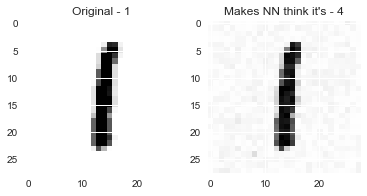

In [17]:
plot_random_adversary(brain_fullgd_trained,show_grad=True)

In [52]:
# x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
# out = brain_fullgd_trained.forward_pass(x)
# make_dot(out)

# RNN

In [23]:
stats, brain_rnn_trained = evaluate_generalization(
    brain_rnn_up_fact, 
    brain_rnn_down_fact, 
    n_up, 
    n_down, 
    dataset_up='halfspace',dataset_down='mnist', 
    num_runs=1, 
    num_rule_epochs=20, 
    num_epochs_upstream=num_epochs_upstream, num_epochs_downstream=num_epochs_downstream,get_model=True
)

 ... (more hidden) ...

Run 1 / 1...
Meta-learning on halfspace...


 ... (more hidden) ...
..\LocalNetBase.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.rnn_rule = torch.tensor(rule).flatten().double()


Last loss: 0.3370
Last train accuracy: 0.9800
Last test accuracy: 0.9691
Training NEW brain instance on mnist...
mnist_train: 60000
mnist_test: 10000
INITIAL train accuracy: 0.1036
INITIAL test accuracy: 0.1058
Epoch 1 / 1 ...


 ... (more hidden) ...


Last loss: 2.3445
Last train accuracy: 0.1000
Last test accuracy: 0.1000



In [53]:
#plot_random_adversary(brain_rnn_trained,show_grad=False)

In [54]:
# x = torch.zeros(1, 784, dtype=torch.double, requires_grad=True)
# out = brain_rnn_trained.forward_pass(x)
# make_dot(out)

# Plot Adversarial Performance

In [62]:
from AdversarialExamples import epsilon_sensitivity_trend
%load_ext autoreload
%autoreload 2

models = {
    'Full GD' : brain_fullgd_trained,
    'Plasticity Prepost' : brain_prepost_trained,
    'Plasticity Prepost Count - L2' : brain_prepostcount_trained,
    'Plasticity Prepost Count - L3' : brain_prepostcount_l3_trained,
    #'RNN(rounds=3)' : brain_rnn_trained,    
}
trend, epsilons = epsilon_sensitivity_trend(models,zip(mnist_X_test,mnist_y_test),brain_fullgd_trained.m,limit=None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Base Test Data Size:  1208
Model,EPS,Acc Full GD 0.0 1.0
Model,EPS,Acc Plasticity Prepost 0.0 1.0
Model,EPS,Acc Plasticity Prepost Count - L2 0.0 1.0
Model,EPS,Acc Plasticity Prepost Count - L3 0.0 1.0
Model,EPS,Acc Full GD 0.5 0.940594829454351
Model,EPS,Acc Plasticity Prepost 0.5 0.9715745687729301
Model,EPS,Acc Plasticity Prepost Count - L2 0.5 0.9319727891156463
Model,EPS,Acc Plasticity Prepost Count - L3 0.5 0.8949752580649898
Model,EPS,Acc Full GD 1.0 0.4232164176660014
Model,EPS,Acc Plasticity Prepost 1.0 0.934866999291474
Model,EPS,Acc Plasticity Prepost Count - L2 1.0 0.9109479129302045
Model,EPS,Acc Plasticity Prepost Count - L3 1.0 0.8416748515863093
Model,EPS,Acc Full GD 1.5 0.28937260997522657
Model,EPS,Acc Plasticity Prepost 1.5 0.9286375049557288
Model,EPS,Acc Plasticity Prepost Count - L2 1.5 0.904145191841769
Model,EPS,Acc Plasticity Prepost Count - L3 1.5 0.8435873554811048
Model,E

Saving figure to: figs/robustness_comparison_uphalfspace_downmnist


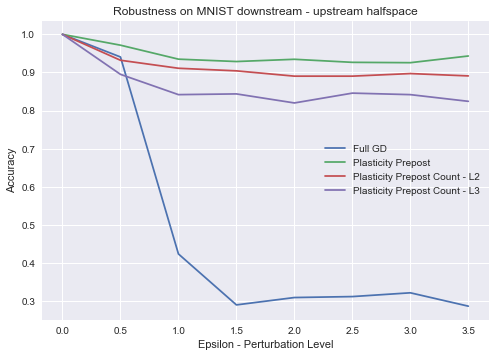

In [63]:
fig, ax = plt.subplots()
for model_name, series in trend.items():
    plt.plot(epsilons,series, label=model_name)
    
ax.set_xlabel('Epsilon - Perturbation Level')
ax.set_ylabel('Accuracy')
ax.set_title('Robustness on MNIST downstream - upstream halfspace')
plt.legend()

save_name = 'figs/robustness_comparison_uphalfspace_downmnist'

print('Saving figure to:', save_name)
plt.savefig(save_name + '.pdf', dpi=192)
plt.savefig(save_name + '.png', dpi=192)
plt.show()